In [1]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Disable warinings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score
)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Epileptic Seizure Recognition
* 1 - Recording of seizure activity
* 2 - They recorder the EEG from the area where the tumor was located
* 3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area
* 4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed
* 5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

In [4]:
df = pd.read_csv('data/Epileptic Seizure Recognition.csv')

In [5]:
df['y'] -= 1 # sparse_categorical_crossentropy wants indices from 0 ... num_cat-1

In [6]:
X = df.values[:,1:-1] 
# y = pd.get_dummies(df['y']).values
y = df['y'].values

print(f'X.shape={X.shape} | y.shape={y.shape}')

X.shape=(11500, 178) | y.shape=(11500,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# scaler = MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train = X_train.reshape(-1,178,1)
X_test  = X_test.reshape(-1,178,1)
print(f'X_train.shape={X_train.shape} | X_test.shape={X_test.shape}')

# y_train = y_train.reshape(-1,1)
# y_test  = y_test.reshape(-1,1)
print(f'y_train.shape={y_train.shape}        | y_test.shape={y_test.shape}')

X_train.shape=(7705, 178, 1) | X_test.shape=(3795, 178, 1)
y_train.shape=(7705,)        | y_test.shape=(3795,)


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(178,1), return_sequences=True),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [9]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=50,
    verbose=0
)

<AxesSubplot: >

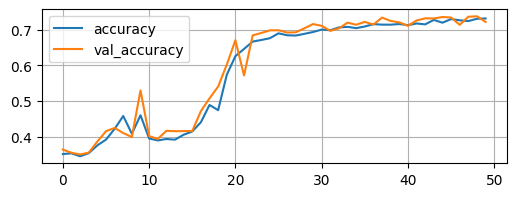

In [11]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(figsize=(6,2),grid=True)

In [12]:
model.evaluate(X_test, y_test)

119/119 [==============================] - 1s 11ms/step - loss: 0.5773 - accuracy: 0.7223


[0.5772630572319031, 0.7222661375999451]

In [13]:
confusion_matrix(y_true=y_test, y_pred=np.argmax(model(X_test), axis=1))

array([[737,  20,   7,   6,   0],
       [ 13, 201, 466,  14,  57],
       [  5,  53, 587,  17,  83],
       [  0,   5,   4, 603, 153],
       [  0,   7,  12, 132, 613]])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 178, 64)           16896     
                                                                 
 dropout (Dropout)           (None, 178, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 54,405
Trainable params: 54,405
Non-traina

## Define the components

### The encoder layer

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

In [21]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(        
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1
    ) 
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [22]:
class FixedPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, dropout=0.1, max_len=1024, scale_factor=1.0):
        super().__init__()        
        self.d_model = d_model        
        self.pos_encoding = positional_encoding(length=max_len, depth=d_model)
        self.pos_encoding *= scale_factor
        
    def call(self, x):
        length = tf.shape(x)[1]
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :self.d_model]
        return x

In [23]:
class LearnablePositionalEncoding(tf.keras.layers.Layer):    
    def __init__(self, d_model, max_len=1024):        
        super().__init__()        
        self.d_model = d_model        
        self.max_len = max_len
        
        self.W_pos = self.add_weight(
            shape=(self.max_len, self.d_model), initializer="random_normal", 
            trainable=True
        )

    def call(self, x):
        length = tf.shape(x)[1]
        x = x + self.W_pos[tf.newaxis, :length, :self.d_model]
        return x

In [24]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0):
        super().__init__()        
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])        
        self.add = tf.keras.layers.Add()
        self.batch_norm = tf.keras.layers.BatchNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.batch_norm(x) 
        return x

In [29]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0):
        super().__init__()        
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)        
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.add = tf.keras.layers.Add()        
        self.ffn = FeedForward(d_model, dff, dropout_rate=dropout_rate)

    def call(self, x):        
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.batch_norm(x)        
        x = self.ffn(x)
        return x

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

In [53]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, feat_dim, d_model, num_heads, num_layers, dim_feedforward, dropout_rate=0,
                 pos_encoding='fixed', activation='gelu', norm='BatchNorm', max_len=1024, freeze=False):
        
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.linear_in = tf.keras.layers.Dense(d_model)
        self.pos_encoding = LearnablePositionalEncoding(d_model=d_model, max_len=max_len) 
        # self.pos_encoding = FixedPositionalEncoding(d_model=d_model, max_len=max_len) 
        
        self.enc_layers = [            
            EncoderLayer(
                d_model=d_model,
                num_heads=num_heads,
                dff=dim_feedforward,
                dropout_rate=dropout_rate
            ) for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)   
        self.linear_out = tf.keras.layers.Dense(feat_dim)
        
    def call(self, x):
        x = self.linear_in(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
            
        x = self.linear_out(x)
            
        return x

In [58]:
encoder = Encoder(
    feat_dim=1,
    d_model=20, 
    num_heads=8, 
    num_layers=4,
    dim_feedforward=128, 
    dropout_rate=0.1, 
    max_len=1024
)

In [59]:
encoder(X_train[:64]).shape

TensorShape([64, 178, 1])

### Time-Series Encoder

In [42]:
def masked_loss(label, pred):
    
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    
    
    mask = label != 0
    
    match = match & mask
    
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [103]:
def masked_mse(label, pred):
    
    mask = label != 0
    loss_object = tf.keras.losses.MeanSquaredError(reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    mask = tf.squeeze(mask)

    loss *= mask
    
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

In [108]:
tst_encoder = tf.keras.models.Sequential([
    Encoder(        
        feat_dim=1,
        d_model=10, 
        num_heads=8, 
        num_layers=8,
        dim_feedforward=256, 
        dropout_rate=0.2, 
        max_len=1024      
    ),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(5, activation='softmax')
])

In [109]:
# tst_encoder.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
tst_encoder.compile(loss=masked_mse, optimizer='adam')

In [ ]:
ts_history = tst_encoder.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=1024,
    verbose=1
)

In [110]:
masked_X_train = X_train*np.random.randint(0,2,size=X_train.shape)
masked_X_test  = X_test*np.random.randint(0,2,size=X_test.shape)

ts_history = tst_encoder.fit(
    masked_X_train, X_train, 
    validation_data=(masked_X_test, X_test),
    epochs=50,
    batch_size=1024,
    verbose=1
)

Epoch 1/50
8/8 [==============================] - 18s 583ms/step - loss: 1.0288 - val_loss: 0.6306
Epoch 2/50
8/8 [==============================] - 3s 426ms/step - loss: 0.5932 - val_loss: 0.7736
Epoch 3/50
8/8 [==============================] - 3s 421ms/step - loss: 0.5574 - val_loss: 0.7076
Epoch 4/50
8/8 [==============================] - 3s 423ms/step - loss: 0.5449 - val_loss: 0.6258
Epoch 5/50
8/8 [==============================] - 3s 429ms/step - loss: 0.5336 - val_loss: 0.5772
Epoch 6/50
8/8 [==============================] - 3s 427ms/step - loss: 0.5272 - val_loss: 0.5233
Epoch 7/50
8/8 [==============================] - 3s 423ms/step - loss: 0.5220 - val_loss: 0.5126
Epoch 8/50
8/8 [==============================] - 3s 435ms/step - loss: 0.5188 - val_loss: 0.5074
Epoch 9/50
8/8 [==============================] - 3s 430ms/step - loss: 0.5162 - val_loss: 0.5071
Epoch 10/50
8/8 [==============================] - 3s 431ms/step - loss: 0.5145 - val_loss: 0.5114
Epoch 11/50
8/8 [=

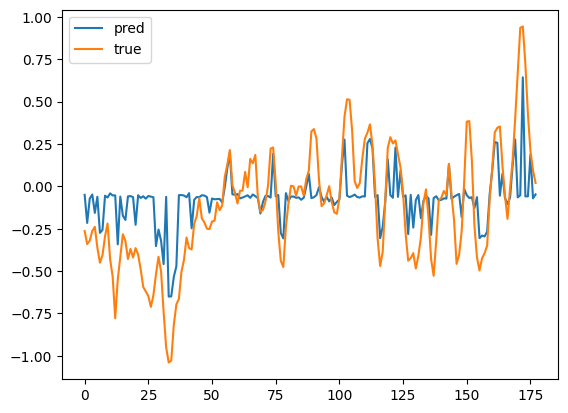

In [120]:
idx=np.random.randint(low=0, high=X_train.shape[0])

predicted    = tf.squeeze(tst_encoder(masked_X_train[idx:idx+1])).numpy()
ground_truth = tf.squeeze(X_train[idx:idx+1]).numpy()

plt.plot(predicted, label='pred')
plt.plot(ground_truth, label='true')
plt.legend()

In [ ]:
pd.DataFrame(ts_history.history)[['accuracy','val_accuracy']].plot(figsize=(6,2),grid=True)

In [ ]:
tst_encoder.evaluate(X_test, y_test)

In [72]:
confusion_matrix(y_true=y_test, y_pred=np.argmax(tst_encoder(X_test), axis=1))

array([[694,   2,   0,  73,   1],
       [ 48,  87, 255, 176, 185],
       [  5,  73, 313, 143, 211],
       [ 25,  37, 135, 228, 340],
       [  0,  97, 389,  16, 262]])

In [73]:
tst_encoder.summary()

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_13 (Encoder)        (None, 178, 1)            81599     
                                                                 
 flatten_1 (Flatten)         (None, 178)               0         
                                                                 
 dense_168 (Dense)           (None, 5)                 895       
                                                                 
Total params: 82,494
Trainable params: 82,174
Non-trainable params: 320
_________________________________________________________________
